# Exploring Dandiset 001361: A flexible hippocampal population code for experience relative to reward

**Dandiset Version:** 0.250406.0045

---

*Disclaimer: This notebook was primarily AI-generated (by Minicline) and has not been fully verified by human experts. Please be cautious when interpreting the code or results. Always cross-reference with official documentation and relevant scientific literature.*

---

## Overview of the Dandiset

This Dandiset, titled "A flexible hippocampal population code for experience relative to reward," contains 2-photon imaging and behavioral data from hippocampal area CA1 as mice navigated virtual environments with changing hidden reward locations. The study investigated how hippocampal ensembles flexibly encode multiple aspects of experience while amplifying behaviorally relevant information.

**Key aspects investigated:**
- How hippocampal place cell activity spans spatial and non-spatial episodes.
- Whether hippocampal activity encodes entire sequences of events relative to reward.
- How neural representations update when reward locations change.
- The relationship between changes in reward-relative firing and behavioral adaptations.

**Experimental techniques:**
- Two-photon calcium imaging of hippocampal CA1 neurons.
- Virtual reality navigation tasks for mice.

**Data available:**
- NWB (Neurodata Without Borders) files containing:
    - Two-photon imaging data (raw and processed, including fluorescence traces, deconvolved activity, and ROI segmentation).
    - Behavioral data (position, speed, licks, reward delivery, trial information).

**Link to the Dandiset:** [https://dandiarchive.org/dandiset/001361/0.250406.0045](https://dandiarchive.org/dandiset/001361/0.250406.0045)

## What this notebook covers

This notebook will guide you through the initial steps of accessing and exploring the data within Dandiset 001361. We will cover:
1. Listing required Python packages.
2. Connecting to the DANDI Archive and retrieving basic information about the Dandiset using the DANDI API.
3. Listing some assets (NWB files) within the Dandiset.
4. Loading a specific NWB file from the Dandiset.
5. Exploring basic metadata and structure of the loaded NWB file.
6. Visualizing behavioral data, such as the mouse's position and speed over time.
7. Visualizing summary 2-photon imaging data, such as mean fluorescence, max projection, and pixel correlation images.
8. Visualizing ROI segmentation results (spatial footprints of detected cells).
9. Plotting example fluorescence traces from selected neurons.
10. Plotting example neural activity (deconvolved) as a function of the animal's position on the track.

The goal is to provide a starting point for users to understand how to access and begin analyzing the rich dataset provided in this Dandiset.

## Required Packages

To run this notebook, you will need the following Python packages installed. We assume these are already available in your Python environment.

- `dandi` (for interacting with the DANDI Archive)
- `pynwb` (for working with NWB files)
- `h5py` (dependency for pynwb, for HDF5 file access)
- `remfile` (for streaming remote HDF5 files)
- `numpy` (for numerical operations)
- `matplotlib` (for plotting)
- `seaborn` (for enhanced plotting aesthetics)
- `scipy` (for scientific computing, e.g., interpolation)

This notebook does **not** include `pip install` commands. Please ensure these packages are installed in your environment before proceeding.

## 1. Connecting to DANDI and Getting Dandiset Information

In [1]:
from itertools import islice
from dandi.dandiapi import DandiAPIClient

# Connect to DANDI archive
client = DandiAPIClient()

# Specify Dandiset ID and version
dandiset_id = "001361"
version_id = "0.250406.0045"

# Get the Dandiset object
try:
    dandiset = client.get_dandiset(dandiset_id, version_id)
    print(f"Successfully connected to Dandiset: {dandiset_id}, Version: {version_id}\n")

    # Print basic information about the Dandiset
    metadata = dandiset.get_raw_metadata() # Using get_raw_metadata for more detailed fields if needed
    print(f"Dandiset Name: {metadata.get('name', 'N/A')}")
    dandiset_url = f"https://dandiarchive.org/dandiset/{dandiset_id}/{version_id}"
    print(f"Dandiset URL: {dandiset_url}")
    print(f"Description: {metadata.get('description', 'N/A')[:300]}...") # Print first 300 chars of description

    # List some assets in the Dandiset
    assets = dandiset.get_assets()
    print("\nFirst 5 assets:")
    for asset_count, asset in enumerate(islice(assets, 5)):
        print(f"- Path: {asset.path} (ID: {asset.identifier}, Size: {asset.size / (1024*1024):.2f} MB)")
        if asset_count == 0: # Store the first asset for later use
            first_asset_path = asset.path
            first_asset_id = asset.identifier
            first_asset_url = f"https://api.dandiarchive.org/api/assets/{first_asset_id}/download/"

except Exception as e:
    print(f"Error connecting to Dandiset or retrieving metadata: {e}")
    first_asset_path = None # Ensure it's defined even on error

Successfully connected to Dandiset: 001361, Version: 0.250406.0045

Dandiset Name: A flexible hippocampal population code for experience relative to reward
Dandiset URL: https://dandiarchive.org/dandiset/001361/0.250406.0045
Description: 2-photon imaging and behavioral data from hippocampal area CA1 during virtual reality navigation in mice. Included in Sosa, Plitt, & Giocomo, "A flexible hippocampal population code for experience relative to reward," Nature Neuroscience.

To reinforce rewarding behaviors, events leading up to and f...

First 5 assets:
- Path: sub-m11/sub-m11_ses-05_behavior+ophys.nwb (ID: a22cc1da-b5e8-4fea-a770-7b83a6e79656, Size: 94.71 MB)
- Path: sub-m11/sub-m11_ses-04_behavior+ophys.nwb (ID: b53ef825-89ca-483e-abeb-b38a0ae9293c, Size: 85.52 MB)
- Path: sub-m11/sub-m11_ses-07_behavior+ophys.nwb (ID: 27481b95-aeb2-4108-b7ac-b3859892da7a, Size: 114.17 MB)
- Path: sub-m11/sub-m11_ses-06_behavior+ophys.nwb (ID: 5a5da0ea-5e7a-497b-a3aa-7e6ee1628bde, Size: 90.23 MB)
- Pa

## 2. Loading an NWB File

We will now load one of the NWB files from the Dandiset. For this demonstration, we will use the first NWB file listed above.

The NWB file chosen for this example is: `sub-m11/sub-m11_ses-03_behavior+ophys.nwb` (Asset ID: `d77ea78a-8978-461d-9d11-3c5cef860d82`).

The direct download URL for this asset is: `https://api.dandiarchive.org/api/assets/d77ea78a-8978-461d-9d11-3c5cef860d82/download/`

We will use `pynwb`, `h5py`, and `remfile` to stream and read the NWB file directly from its URL.

In [2]:
import pynwb
import h5py
import remfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d

# --- Configuration for NWB file loading ---
# This URL and asset ID were determined during the exploratory phase
# NWB File: sub-m11/sub-m11_ses-03_behavior+ophys.nwb
NWB_ASSET_ID = "d77ea78a-8978-461d-9d11-3c5cef860d82"
NWB_FILE_URL = f"https://api.dandiarchive.org/api/assets/{NWB_ASSET_ID}/download/"
NWB_FILE_PATH_IN_DANDISET = "sub-m11/sub-m11_ses-03_behavior+ophys.nwb" # For display purposes

print(f"Attempting to load NWB file: {NWB_FILE_PATH_IN_DANDISET}")
print(f"From URL: {NWB_FILE_URL}\n")

io = None
remote_f = None # Renamed to avoid conflict with 'remote_file' in a different scope if copy-pasting
nwbfile = None

try:
    remote_f = remfile.File(NWB_FILE_URL)
    h5_f = h5py.File(remote_f, 'r')
    io = pynwb.NWBHDF5IO(file=h5_f, mode='r', load_namespaces=True)
    nwbfile = io.read()
    print("NWB file loaded successfully!")
except Exception as e:
    print(f"Error loading NWB file: {e}")
    print("Please ensure the DANDI CLI and necessary libraries (pynwb, h5py, remfile) are installed and the URL is correct.")
    print("Subsequent cells requiring 'nwbfile' may fail.")

Attempting to load NWB file: sub-m11/sub-m11_ses-03_behavior+ophys.nwb
From URL: https://api.dandiarchive.org/api/assets/d77ea78a-8978-461d-9d11-3c5cef860d82/download/



/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.8.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


NWB file loaded successfully!


### 2.1. Basic NWB File Information

Let's look at some of the high-level metadata contained within the loaded NWB file.

In [3]:
if nwbfile:
    print(f"Identifier: {nwbfile.identifier}")
    print(f"Session Description: {nwbfile.session_description}")
    print(f"Session Start Time: {nwbfile.session_start_time}")
    print(f"Experimenter(s): {nwbfile.experimenter}")
    print(f"Lab: {nwbfile.lab}")
    print(f"Institution: {nwbfile.institution}")
    print(f"Related Publications: {nwbfile.related_publications}")
    
    if nwbfile.subject:
        print("\nSubject Information:")
        print(f"- Subject ID: {nwbfile.subject.subject_id}")
        print(f"- Species: {nwbfile.subject.species}")
        print(f"- Sex: {nwbfile.subject.sex}")
        print(f"- Age: {nwbfile.subject.age}")
        print(f"- Description: {nwbfile.subject.description}")
else:
    print("nwbfile not loaded, skipping metadata display.")

Identifier: /data/InVivoDA/GCAMP11/23_02_2023/Env1_LocationB_to_A
Session Description: processed suite2p data
Session Start Time: 2023-02-23 00:00:00-08:00
Experimenter(s): ('Mari Sosa',)
Lab: None
Institution: None
Related Publications: None

Subject Information:
- Subject ID: m11
- Species: Mus musculus
- Sex: M
- Age: None
- Description: None


### 2.2. Exploring NWB File Contents with Neurosift

For interactive exploration of this NWB file's contents and structure, you can use Neurosift.

**Link to this NWB file on Neurosift:**
[https://neurosift.app/nwb?url={NWB_FILE_URL}&dandisetId={dandiset_id}&dandisetVersion={version_id}](https://neurosift.app/nwb?url={NWB_FILE_URL}&dandisetId={dandiset_id}&dandisetVersion={version_id})

(Replace `{NWB_FILE_URL}`, `{dandiset_id}`, and `{version_id}` with the actual values if the link doesn't render correctly with f-string interpolation in markdown directly)

For this specific file (`sub-m11/sub-m11_ses-03_behavior+ophys.nwb`):
[https://neurosift.app/nwb?url=https://api.dandiarchive.org/api/assets/d77ea78a-8978-461d-9d11-3c5cef860d82/download/&dandisetId=001361&dandisetVersion=0.250406.0045](https://neurosift.app/nwb?url=https://api.dandiarchive.org/api/assets/d77ea78a-8978-461d-9d11-3c5cef860d82/download/&dandisetId=001361&dandisetVersion=0.250406.0045)

### 2.3. Overview of Processing Modules

NWB files often organize processed data into "processing modules." Let's list the available modules in this file.

In [4]:
if nwbfile:
    print("Available processing modules:")
    if nwbfile.processing:
        for module_name, module_obj in nwbfile.processing.items():
            print(f"- {module_name}: {module_obj.description}")
            print("  Data interfaces within this module:")
            for interface_name in module_obj.data_interfaces:
                print(f"    - {interface_name}")
    else:
        print("No processing modules found.")
else:
    print("nwbfile not loaded, skipping processing module display.")

Available processing modules:
- behavior: behavior data
  Data interfaces within this module:
    - BehavioralTimeSeries
- ophys: optical physiology processed data
  Data interfaces within this module:
    - Backgrounds_0
    - Deconvolved
    - Fluorescence
    - ImageSegmentation
    - Neuropil


## 3. Visualizing Behavioral Data

The 'behavior' processing module typically contains time series data related to the animal's behavior. Let's plot the mouse's position and speed over time. We will plot a subset of the data for quicker visualization.

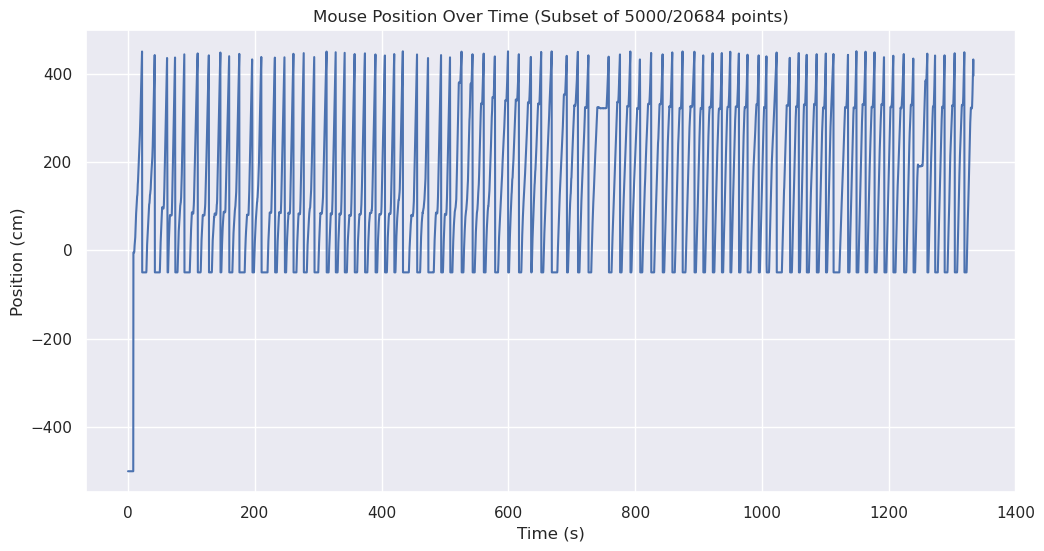

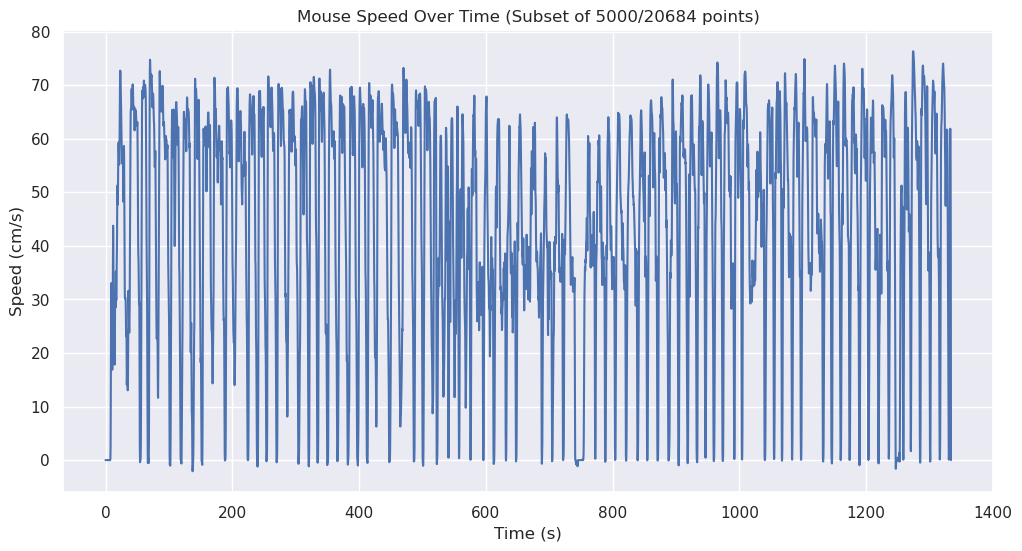

In [5]:
if nwbfile and 'behavior' in nwbfile.processing:
    behavior_module = nwbfile.processing['behavior']
    if 'BehavioralTimeSeries' in behavior_module.data_interfaces:
        behavioral_ts_interface = behavior_module.data_interfaces['BehavioralTimeSeries']
        
        sns.set_theme() # Apply seaborn styling for these plots

        # Plot position over time
        if 'position' in behavioral_ts_interface.time_series:
            position_ts = behavioral_ts_interface.time_series['position']
            
            num_points_total = len(position_ts.data)
            num_points_to_plot = min(num_points_total, 5000)
            indices = np.linspace(0, num_points_total - 1, num_points_to_plot, dtype=int)
            
            position_data_subset = position_ts.data[indices]
            position_timestamps_subset = position_ts.timestamps[indices]

            plt.figure(figsize=(12, 6))
            plt.plot(position_timestamps_subset, position_data_subset)
            plt.xlabel("Time (s)")
            plt.ylabel(f"Position ({position_ts.unit})")
            plt.title(f"Mouse Position Over Time (Subset of {num_points_to_plot}/{num_points_total} points)")
            plt.grid(True)
            plt.show()
        else:
            print("Position time series not found in Behavior module.")

        # Plot speed over time
        if 'speed' in behavioral_ts_interface.time_series:
            speed_ts = behavioral_ts_interface.time_series['speed']

            num_points_total = len(speed_ts.data)
            num_points_to_plot = min(num_points_total, 5000)
            indices = np.linspace(0, num_points_total - 1, num_points_to_plot, dtype=int)

            speed_data_subset = speed_ts.data[indices]
            speed_timestamps_subset = speed_ts.timestamps[indices]
            
            plt.figure(figsize=(12, 6))
            plt.plot(speed_timestamps_subset, speed_data_subset)
            plt.xlabel("Time (s)")
            plt.ylabel(f"Speed ({speed_ts.unit})")
            plt.title(f"Mouse Speed Over Time (Subset of {num_points_to_plot}/{num_points_total} points)")
            plt.grid(True)
            plt.show()
        else:
            print("Speed time series not found in Behavior module.")
    else:
        print("BehavioralTimeSeries interface not found in 'behavior' module.")
else:
    print("Behavior module or nwbfile not available.")

**Interpretation of Behavioral Plots:**
The position plot typically shows the mouse moving back and forth along the virtual track, often with "teleportations" at the ends of the track, characteristic of such experimental designs. The speed plot should correlate with this, showing periods of movement (higher speed) and pauses or turns (lower speed).

## 4. Visualizing Summary 2-Photon Imaging Data

The 'ophys' processing module contains optical physiology data. We can start by looking at some summary images provided by Suite2P (a common processing pipeline), often found under a "Backgrounds" or similar interface. These include:
- **Mean Fluorescence Image:** Average intensity across all frames.
- **Max Projection Image:** Maximum intensity at each pixel across all frames. Can highlight bright, active cells.
- **Pixel Correlation Image (Vcorr):** Image showing pixel-wise temporal correlations. Often very good for identifying cell boundaries.

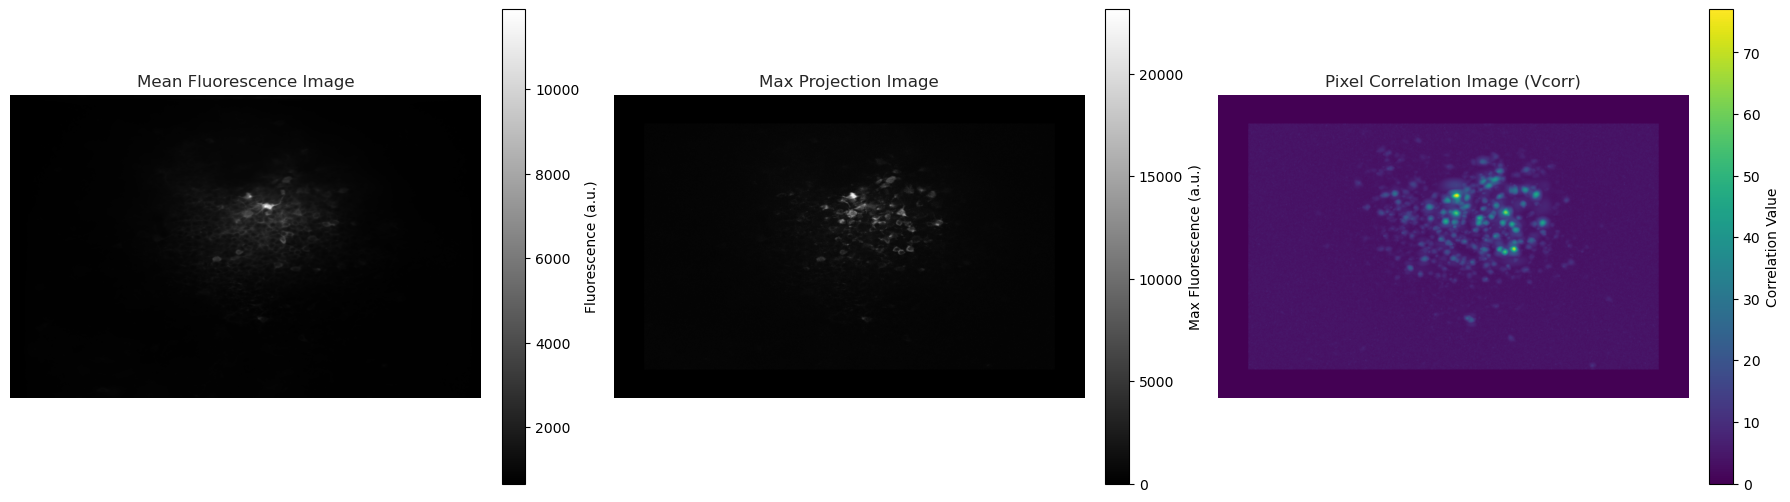

In [6]:
if nwbfile and 'ophys' in nwbfile.processing:
    ophys_module = nwbfile.processing['ophys']
    if 'Backgrounds_0' in ophys_module.data_interfaces:
        backgrounds_interface = ophys_module.data_interfaces['Backgrounds_0']
        
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))
        plt.style.use('default') # Turn off seaborn for these image plots

        # Mean Image
        if 'meanImg' in backgrounds_interface.images:
            mean_img = backgrounds_interface.images['meanImg']
            ax = axs[0]
            im = ax.imshow(mean_img.data[:], cmap='gray')
            ax.set_title("Mean Fluorescence Image")
            ax.axis('off')
            plt.colorbar(im, ax=ax, label="Fluorescence (a.u.)", fraction=0.046, pad=0.04)
        else:
            axs[0].set_title("Mean Image\n(Not found)")
            axs[0].axis('off')

        # Max Projection Image
        if 'max_proj' in backgrounds_interface.images:
            max_proj_img = backgrounds_interface.images['max_proj']
            ax = axs[1]
            im = ax.imshow(max_proj_img.data[:], cmap='gray')
            ax.set_title("Max Projection Image")
            ax.axis('off')
            plt.colorbar(im, ax=ax, label="Max Fluorescence (a.u.)", fraction=0.046, pad=0.04)
        else:
            axs[1].set_title("Max Projection\n(Not found)")
            axs[1].axis('off')

        # Pixel Correlation Image (Vcorr)
        if 'Vcorr' in backgrounds_interface.images:
            vcorr_img = backgrounds_interface.images['Vcorr']
            ax = axs[2]
            im = ax.imshow(vcorr_img.data[:], cmap='viridis') # Viridis is a good default for correlation maps
            ax.set_title("Pixel Correlation Image (Vcorr)")
            ax.axis('off')
            plt.colorbar(im, ax=ax, label="Correlation Value", fraction=0.046, pad=0.04)
        else:
            axs[2].set_title("Vcorr Image\n(Not found)")
            axs[2].axis('off')
            
        plt.tight_layout()
        plt.show()
    else:
        print("Backgrounds_0 interface not found in 'ophys' module.")
else:
    print("Ophys module or nwbfile not available.")

**Interpretation of Summary Images:**
These images give an overview of the imaging field. The mean image shows average brightness, the max projection can help identify putative cells as they are often brighter when active, and the Vcorr image highlights regions of pixels whose activity is correlated over time, which is a strong indicator of cellular structures.

## 5. Visualizing ROI Segmentation Footprints

Processed ophys data usually includes information about detected Regions of Interest (ROIs), which correspond to putative neurons. This is often stored in an `ImageSegmentation` interface, containing a `PlaneSegmentation` table. Let's visualize the spatial footprints of all detected ROIs.

Found PlaneSegmentation with 349 ROIs.


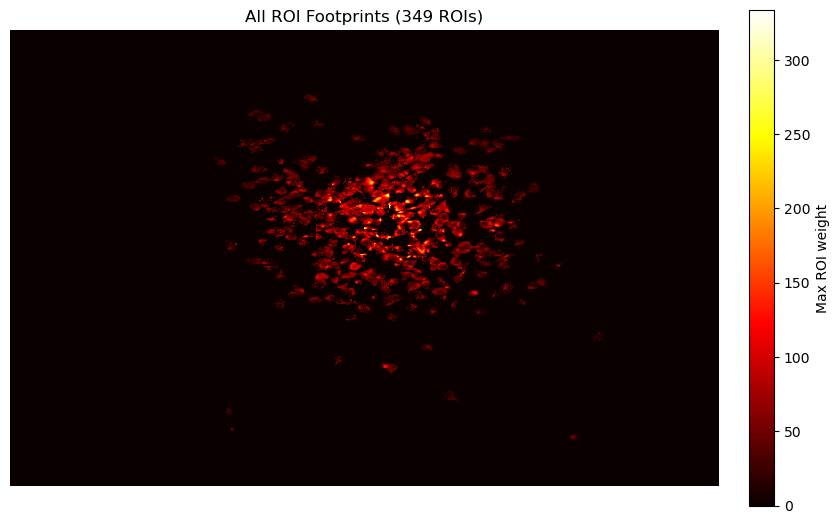

In [7]:
if nwbfile and 'ophys' in nwbfile.processing:
    ophys_module = nwbfile.processing['ophys']
    if 'ImageSegmentation' in ophys_module.data_interfaces:
        image_seg_interface = ophys_module.data_interfaces['ImageSegmentation']
        if 'PlaneSegmentation' in image_seg_interface.plane_segmentations:
            plane_seg = image_seg_interface.plane_segmentations['PlaneSegmentation']
            
            print(f"Found PlaneSegmentation with {len(plane_seg.id)} ROIs.")
            
            # Determine imaging plane dimensions
            # Try from TwoPhotonSeries first, then fallback to a summary image shape
            plane_dimensions = None
            if "TwoPhotonSeries" in nwbfile.acquisition:
                tps = nwbfile.acquisition["TwoPhotonSeries"]
                if hasattr(tps, 'dimension') and tps.dimension is not None :
                    plane_dimensions = tps.dimension[:] # (height, width)
            
            if plane_dimensions is None and 'Backgrounds_0' in ophys_module.data_interfaces:
                 backgrounds_interface = ophys_module.data_interfaces['Backgrounds_0']
                 if 'meanImg' in backgrounds_interface.images:
                    plane_dimensions = backgrounds_interface.images['meanImg'].data.shape
                    print(f"Inferred plane dimensions from meanImg: {plane_dimensions}")

            if plane_dimensions is None or len(plane_dimensions) != 2:
                print("Could not determine imaging plane dimensions accurately. Using default 512x512.")
                plane_dimensions = (512, 512) 

            composite_mask_image = np.zeros(plane_dimensions, dtype=float)
            
            num_rois = len(plane_seg.id)
            for i in range(num_rois):
                pixel_mask_data = plane_seg['pixel_mask'][i] # List of (y, x, weight)
                for y, x, weight in pixel_mask_data:
                    if 0 <= int(y) < plane_dimensions[0] and 0 <= int(x) < plane_dimensions[1]:
                        composite_mask_image[int(y), int(x)] = max(composite_mask_image[int(y), int(x)], weight)
            
            if num_rois > 0:
                plt.style.use('default') # Turn off seaborn for this image plot
                plt.figure(figsize=(10, 10 * plane_dimensions[0]/plane_dimensions[1] if plane_dimensions[1] > 0 else 10))
                im = plt.imshow(composite_mask_image, cmap='hot', interpolation='nearest', vmin=0, vmax=np.max(composite_mask_image) if np.max(composite_mask_image) > 0 else 1)
                plt.title(f"All ROI Footprints ({num_rois} ROIs)")
                plt.colorbar(im, label="Max ROI weight", fraction=0.046, pad=0.04)
                plt.axis('off')
                plt.show()
            else:
                print("No ROIs found to plot.")
        else:
            print("PlaneSegmentation not found in ImageSegmentation interface.")
    else:
        print("ImageSegmentation interface not found in 'ophys' module.")
else:
    print("Ophys module or nwbfile not available.")

**Interpretation of ROI Footprints:**
This plot shows where the segmentation algorithm identified potential cells. The 'hot' colormap highlights the spatial extent of each ROI, with brighter colors indicating pixels more strongly belonging to an ROI. The distribution should roughly match the bright, cell-like areas seen in the summary images.

## 6. Plotting Example Fluorescence Traces

We can now look at the activity of individual neurons over time. We'll select a few ROIs (preferably those identified as 'cells') and plot their fluorescence traces. The `Fluorescence` interface typically stores traces like F_cell (raw fluorescence) or F_neu (neuropil fluorescence). Here we plot from `Fluorescence/plane0`.

Selected 5 ROIs (classified as cells) for plotting.
Plotting traces for ROI IDs: [2, 3, 4, 5, 6]


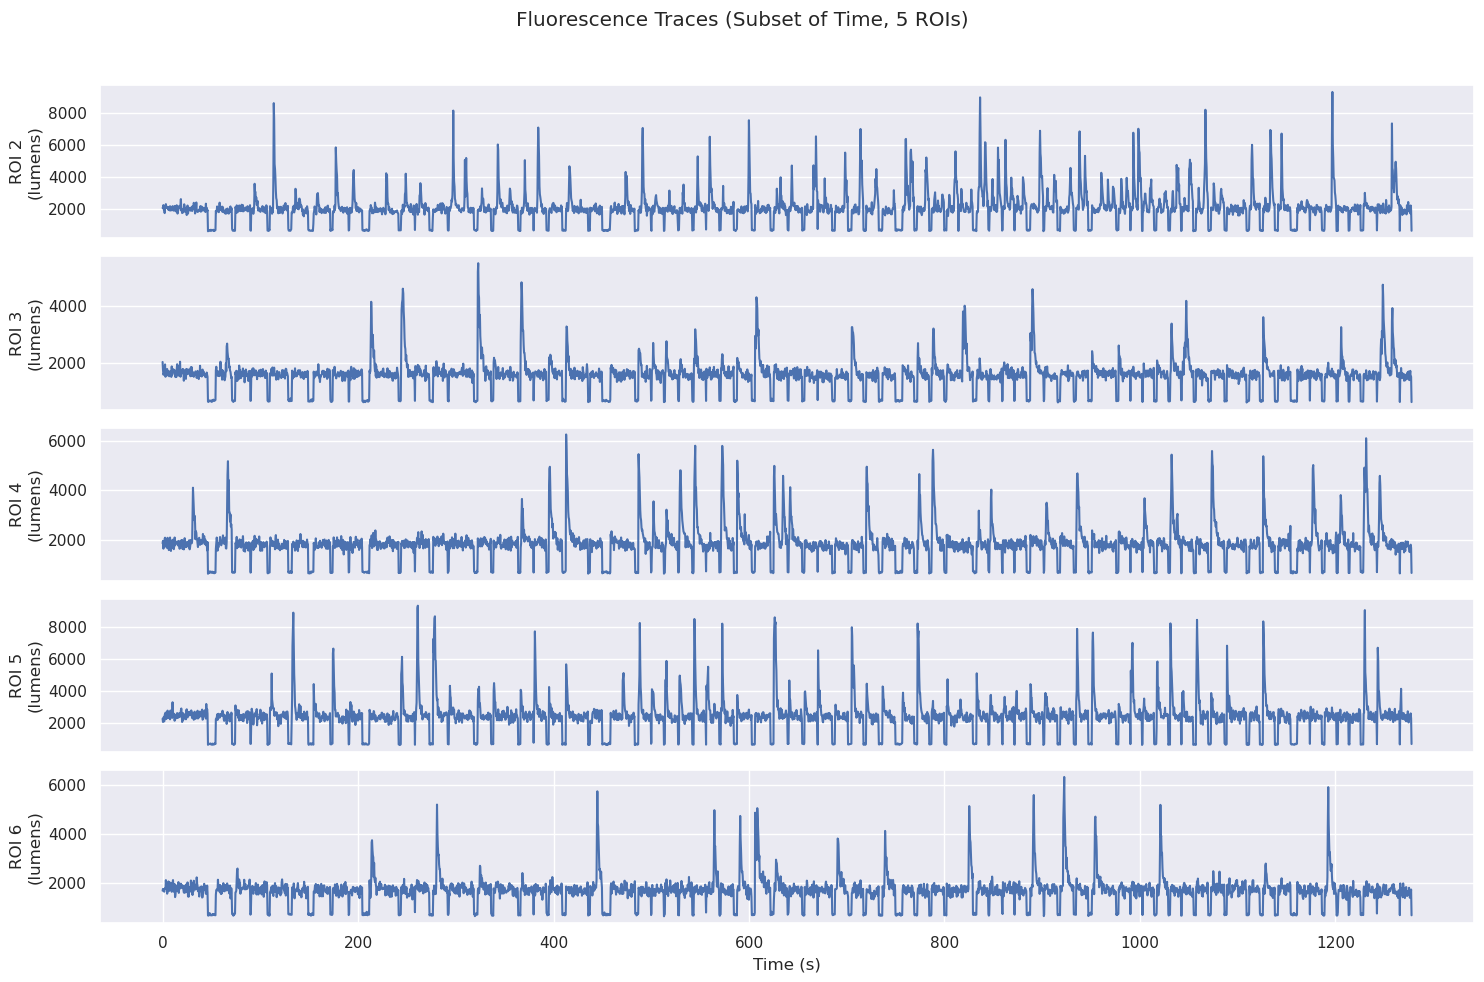

In [8]:
if nwbfile and 'ophys' in nwbfile.processing:
    ophys_module = nwbfile.processing['ophys']
    if 'Fluorescence' in ophys_module.data_interfaces:
        fluorescence_interface = ophys_module.data_interfaces['Fluorescence']
        if 'plane0' in fluorescence_interface.roi_response_series:
            plane0_fluor = fluorescence_interface.roi_response_series['plane0']
            
            roi_table = plane0_fluor.rois.table
            # Suite2p's 'iscell' column often has two sub-columns: [is_cell_bool, probability_of_cell]
            # We are interested in the first one (is_cell_bool == 1)
            iscell_data = roi_table['iscell'].data[:]
            cell_indices_in_table = np.where(iscell_data[:, 0] == 1)[0]
            
            num_rois_total = plane0_fluor.data.shape[1]
            
            if len(cell_indices_in_table) > 0:
                rois_to_plot_indices = cell_indices_in_table[:min(5, len(cell_indices_in_table))]
                print(f"Selected {len(rois_to_plot_indices)} ROIs (classified as cells) for plotting.")
            else:
                print("No ROIs classified as cells by 'iscell' flag. Plotting first few available ROIs.")
                rois_to_plot_indices = np.arange(min(5, num_rois_total))

            actual_roi_ids_plotted = roi_table.id[rois_to_plot_indices]
            print(f"Plotting traces for ROI IDs: {list(actual_roi_ids_plotted)}")

            if len(rois_to_plot_indices) > 0:
                num_timepoints = plane0_fluor.data.shape[0]
                rate = plane0_fluor.rate if plane0_fluor.rate is not None else (1.0 / (plane0_fluor.timestamps[1] - plane0_fluor.timestamps[0]) if plane0_fluor.timestamps is not None and len(plane0_fluor.timestamps) > 1 else 30.0) # Estimate rate if not present
                starting_time = plane0_fluor.starting_time if plane0_fluor.starting_time is not None else (plane0_fluor.timestamps[0] if plane0_fluor.timestamps is not None else 0.0)
                
                time_vector = np.arange(num_timepoints) / rate + starting_time
                
                max_timepoints_to_plot = 3000 
                if num_timepoints > max_timepoints_to_plot:
                    time_indices_to_plot = np.linspace(0, num_timepoints - 1, max_timepoints_to_plot, dtype=int)
                    time_vector_subset = time_vector[time_indices_to_plot]
                    plot_title_suffix = f"(Subset of Time, {len(rois_to_plot_indices)} ROIs)"
                else:
                    time_indices_to_plot = slice(None) 
                    time_vector_subset = time_vector
                    plot_title_suffix = f"({len(rois_to_plot_indices)} ROIs)"

                # Load data: first select ROIs (columns), then select timepoints (rows) from the  NumPy array
                traces_data_all_time_selected_rois = plane0_fluor.data[:, rois_to_plot_indices]
                traces_data_subset = traces_data_all_time_selected_rois[time_indices_to_plot, :]
                
                sns.set_theme()
                plt.figure(figsize=(15, 2 * len(rois_to_plot_indices)))
                
                for i in range(traces_data_subset.shape[1]):
                    plt.subplot(len(rois_to_plot_indices), 1, i + 1)
                    plt.plot(time_vector_subset, traces_data_subset[:, i])
                    plt.ylabel(f"ROI {actual_roi_ids_plotted[i]}\n({plane0_fluor.unit})")
                    if i < len(rois_to_plot_indices) - 1:
                        plt.xticks([])
                
                plt.xlabel("Time (s)")
                plt.suptitle(f"Fluorescence Traces {plot_title_suffix}")
                plt.tight_layout(rect=[0, 0, 1, 0.96])
                plt.show()
            else:
                print("No ROIs available to plot fluorescence traces.")
        else:
            print("Fluorescence/plane0 not found in ophys module.")
    else:
        print("Fluorescence interface not found in 'ophys' module.")
else:
    print("Ophys module or nwbfile not available.")

**Interpretation of Fluorescence Traces:**
These plots show the change in fluorescence intensity for selected neurons over time. Increases in fluorescence (calcium transients) are typically interpreted as neural activity. Different neurons will show different activity patterns.

## 7. Plotting Neural Activity vs. Position (Place Fields)

A common analysis in hippocampal research is to look for "place cells" – neurons that fire preferentially when the animal is in a specific location. We can create a simple version of this by plotting the mean deconvolved neural activity against the animal's position on the track for a couple of neurons. We'll use deconvolved activity as it often provides a cleaner signal of neural events.

Plotting activity vs. position for ROI IDs: [2, 6]


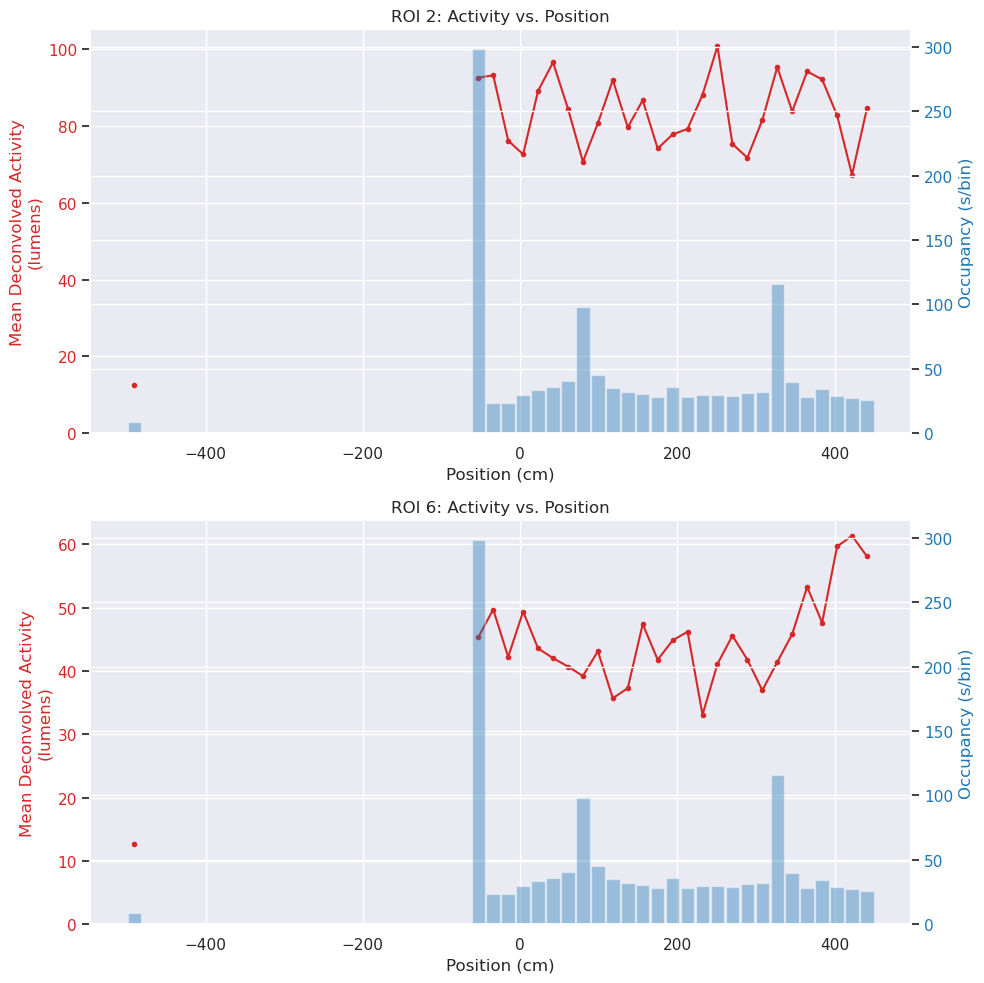

In [9]:
if nwbfile and 'ophys' in nwbfile.processing and 'behavior' in nwbfile.processing:
    ophys_module = nwbfile.processing['ophys']
    behavior_module = nwbfile.processing['behavior']

    if ('Deconvolved' in ophys_module.data_interfaces and
        'BehavioralTimeSeries' in behavior_module.data_interfaces):
        
        deconvolved_interface = ophys_module.data_interfaces['Deconvolved']
        behavioral_ts_interface = behavior_module.data_interfaces['BehavioralTimeSeries']

        if ('plane0' in deconvolved_interface.roi_response_series and
            'position' in behavioral_ts_interface.time_series):
            
            plane0_deconv = deconvolved_interface.roi_response_series['plane0']
            position_ts = behavioral_ts_interface.time_series['position']

            roi_table = plane0_deconv.rois.table
            iscell_data = roi_table['iscell'].data[:]
            cell_indices_in_table = np.where(iscell_data[:, 0] == 1)[0]

            # Select ROIs for analysis (e.g., first two 'cells', or specific ones identified before)
            # Let's try to use ROI IDs 2 and 6, which were used in exploration script
            rois_to_analyze_target_ids = [2, 6] 
            rois_to_analyze_indices = []
            
            # Find the table indices for the target ROI IDs, ensuring they are cells
            all_roi_ids_in_table = list(roi_table.id[:])
            for target_id in rois_to_analyze_target_ids:
                try:
                    table_idx = all_roi_ids_in_table.index(target_id)
                    if table_idx in cell_indices_in_table:
                         rois_to_analyze_indices.append(table_idx)
                except ValueError:
                    print(f"Target ROI ID {target_id} not found in table. Skipping.")
            
            if not rois_to_analyze_indices: # Fallback if target ROIs not found/not cells
                if len(cell_indices_in_table) >= 2:
                    rois_to_analyze_indices = cell_indices_in_table[:2]
                    print(f"Using first two cells from table as fallback: Indices {rois_to_analyze_indices}, IDs {list(roi_table.id[rois_to_analyze_indices])}")
                elif len(cell_indices_in_table) == 1:
                    rois_to_analyze_indices = cell_indices_in_table[:1]
                    print(f"Using only one cell from table as fallback: Index {rois_to_analyze_indices}, ID {list(roi_table.id[rois_to_analyze_indices])}")
                else:
                    print("Not enough cells to plot activity vs. position.")
                    rois_to_analyze_indices = []


            if rois_to_analyze_indices:
                actual_roi_ids_plotted = roi_table.id[rois_to_analyze_indices]
                print(f"Plotting activity vs. position for ROI IDs: {list(actual_roi_ids_plotted)}")

                deconv_data_selected_rois = plane0_deconv.data[:, rois_to_analyze_indices]
            
                num_timepoints_ophys = plane0_deconv.data.shape[0]
                rate_ophys = plane0_deconv.rate if plane0_deconv.rate is not None else (1.0/(plane0_deconv.timestamps[1]-plane0_deconv.timestamps[0]) if plane0_deconv.timestamps is not None and len(plane0_deconv.timestamps)>1 else 30)
                start_time_ophys = plane0_deconv.starting_time if plane0_deconv.starting_time is not None else (plane0_deconv.timestamps[0] if plane0_deconv.timestamps is not None else 0)
                time_vector_ophys = np.arange(num_timepoints_ophys) / rate_ophys + start_time_ophys
                
                position_data_full = position_ts.data[:]
                position_timestamps_full = position_ts.timestamps[:]

                # Ensure timestamps are monotonic for interpolation
                if not np.all(np.diff(position_timestamps_full) > 0):
                    sort_indices = np.argsort(position_timestamps_full)
                    position_timestamps_full = position_timestamps_full[sort_indices]
                    position_data_full = position_data_full[sort_indices]
                
                interp_func = interp1d(position_timestamps_full, position_data_full, kind='nearest', bounds_error=False, fill_value=(position_data_full[0], position_data_full[-1]))
                position_interpolated = interp_func(time_vector_ophys)

                sns.set_theme()
                num_selected_rois_plot = deconv_data_selected_rois.shape[1]
                plt.figure(figsize=(10, 5 * num_selected_rois_plot))

                for i in range(num_selected_rois_plot):
                    roi_id_for_plot = actual_roi_ids_plotted[i]
                    activity = deconv_data_selected_rois[:, i]
                    
                    plt.subplot(num_selected_rois_plot, 1, i + 1)
                    
                    num_bins = 50
                    track_min = np.min(position_interpolated)
                    track_max = np.max(position_interpolated)
                    # Ensure bins are reasonable even if track_min == track_max (e.g. if position data is all same)
                    if track_min == track_max:
                        bins = np.linspace(track_min - 0.5, track_max + 0.5, num_bins + 1)
                    else:
                        bins = np.linspace(track_min, track_max, num_bins + 1)
                    bin_centers = (bins[:-1] + bins[1:]) / 2
                    
                    mean_activity_in_bin = np.zeros(num_bins)
                    occupancy_in_bin_seconds = np.zeros(num_bins) # Time spent in each bin
                    
                    digitized_position = np.digitize(position_interpolated, bins)
                    
                    for bin_k in range(num_bins): # Bin indices from np.digitize are 1-based for bins[0] to bins[num_bins-1]
                        # So, if digitized_position == k+1, it falls in bins[k] to bins[k+1]
                        mask = (digitized_position == (bin_k + 1))
                        if np.any(mask):
                            mean_activity_in_bin[bin_k] = np.mean(activity[mask])
                            occupancy_in_bin_seconds[bin_k] = np.sum(mask) / rate_ophys # sum(mask) is num samples in bin
                        else:
                            mean_activity_in_bin[bin_k] = np.nan 
                    
                    ax1 = plt.gca()
                    color = 'tab:red'
                    ax1.set_xlabel(f"Position ({position_ts.unit})")
                    ax1.set_ylabel(f"Mean Deconvolved Activity\n({plane0_deconv.unit})", color=color)
                    ax1.plot(bin_centers, mean_activity_in_bin, color=color, marker='.', linestyle='-')
                    ax1.tick_params(axis='y', labelcolor=color)
                    ax1.set_ylim(bottom=0) # Activity is non-negative
                    
                    ax2 = ax1.twinx()
                    color = 'tab:blue'
                    ax2.set_ylabel('Occupancy (s/bin)', color=color) 
                    ax2.bar(bin_centers, occupancy_in_bin_seconds, width=(bins[1]-bins[0])*0.9, alpha=0.4, color=color)
                    ax2.tick_params(axis='y', labelcolor=color)
                    ax2.set_ylim(bottom=0)
                    
                    plt.title(f"ROI {roi_id_for_plot}: Activity vs. Position")

                plt.tight_layout()
                plt.show()
        else:
            print("Required data (Deconvolved/plane0 or position) not found.")
    else:
        print("Required modules (ophys or behavior) or interfaces not found.")
else:
    print("Ophys/Behavior modules or nwbfile not available.")

**Interpretation of Activity vs. Position Plots:**
If a neuron is a place cell, its activity (red line) should be consistently elevated when the animal is in a particular part of the track (its "place field"). The blue bars show the occupancy – how much time the animal spent in each spatial bin. It's important to consider occupancy because if an animal spends a lot of time in one place, a neuron might appear to fire more there simply due to increased sampling. True place fields should show elevated activity even when normalized for occupancy (though we haven't done that normalization here, plotting them together gives a good visual intuition).

## 8. Summary and Future Directions

This notebook has demonstrated the initial steps for accessing and exploring Dandiset 001361. We covered:
- Connecting to DANDI and fetching Dandiset metadata.
- Loading a specific NWB file using its remote URL.
- Examining high-level metadata and structure.
- Visualizing key behavioral data (position, speed).
- Displaying summary 2-photon imaging statistics (mean, max-projection, Vcorr images).
- Plotting ROI footprints from segmentation.
- Visualizing example fluorescence traces of selected neurons.
- Creating basic "activity vs. position" plots to hint at spatial tuning.

**Possible Future Directions for Analysis:**

This Dandiset offers many avenues for deeper analysis:
1.  **Detailed Place Field Analysis:** Quantify place fields more rigorously (e.g., information content, field width, stability across trials/sessions). How do place fields change when reward locations are altered?
2.  **Reward-Relative Coding:** The core theme of the paper is reward-relative coding. Analyze neural activity aligned to reward delivery or entry into reward zones. Do cells show firing patterns that are anchored to the reward location, even when it moves?
3.  **Population Coding:** Investigate how ensembles of neurons collectively represent space, reward, and other task variables. Techniques like population vector analysis, dimensionality reduction (PCA, t-SNE, UMAP), and decoders could be applied.
4.  **Behavioral Correlates:** Correlate neural activity with more nuanced behavioral variables like licking patterns, acceleration, or specific trial events (e.g., trial start/end, teleportation).
5.  **Learning-Related Changes:** The Dandiset description mentions learning. Analyze how neural representations and behavioral performance evolve across sessions or within sessions as the animal learns new reward locations.
6.  **Cross-Session Analysis:** Compare neural activity and representations across different recording sessions for the same animal.
7.  **Comparison Across Animals:** How consistent are these neural coding principles across different mice in the dataset?

This notebook provides the foundational tools to start asking these more complex questions. Good luck with your exploration!

---
*Notebook generation completed.*

In [10]:
# Close the NWB file if it's still open from the last cell
if 'io' in locals() and io is not None:
    try:
        if not h5_f.id.valid: # Check if file is already closed
             print("HDF5 file object is invalid, likely already closed.")
        else:
            print("Closing NWB file at the end of the notebook.")
            io.close()
        # It's also good practice to close the remfile object if it exists
        if 'remote_f' in locals() and remote_f is not None:
            remote_f.close()
    except Exception as e:
        print(f"Error closing NWB file: {e}")
elif nwbfile and not io: # If nwbfile exists but io was not defined in this cell's scope before closing
    print("NWB file was loaded, but 'io' object for closing not found in this cell's final scope. Ensure it was closed previously if opened.")

Closing NWB file at the end of the notebook.


In [11]:
print("Notebook execution finished.")

Notebook execution finished.
